In [1]:
# Importing all the necessary libraries
from tensorflow.keras.datasets import mnist
import torchvision
from sklearn.metrics import accuracy_score
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn import metrics
import numpy as np
import torch
from torch import nn
from collections import defaultdict
from functools import partial
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt
import copy

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Conversion to float
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')
# Normalization
x_train = x_train/255.0
x_test = x_test/255.0


X_train = x_train.reshape(len(x_train),-1)
X_test = x_test.reshape(len(x_test),-1)

In [3]:
print(X_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 784)
(10000, 28, 28)
(60000,)
(10000,)


In [4]:
# What is being done here:
# We are collecting all the images by classes
# Each entry in the 'output' list is 
# a numpy array of all the images by class
output = []
for i in range(10):
    classno = X_train[np.where(y_train==i)]
    output.append(classno)

In [5]:
# What is happening here:
# We are stacking the classes into one output 'total_list'
# In addition, we are also appending the cluster center into each class
# This is needed for the next step: T-Stochastic Nearest Neighbors plotting

total_list = []
indices = []
for number in range(10):
    kmeans = KMedoids(n_clusters = 256)
    kmeans.fit(output[number])
    output[number] = kmeans.cluster_centers_
    total_list.append(output[number][:])
    if not indices:
        indices.append(output[number].shape[0])
    else:         
        indices.append(indices[-1] + output[number].shape[0])
        
total_list = np.concatenate(total_list, axis=0)

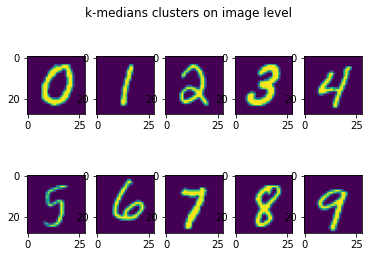

In [6]:
# Printing all the k-means cluster (0-9)
fig, axs = plt.subplots(2,5)
fig.suptitle('k-medians clusters on image level')
for i in range(2):
    for j in range(5):
        axs[i,j].imshow(total_list[indices[5*i + j]-1].reshape(28,28))

In [7]:
# We do the TSNE transform on total_list
from sklearn.manifold import TSNE
tsne_points = TSNE(n_components=2, perplexity = 50, n_iter = 2000).fit_transform(total_list)

c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


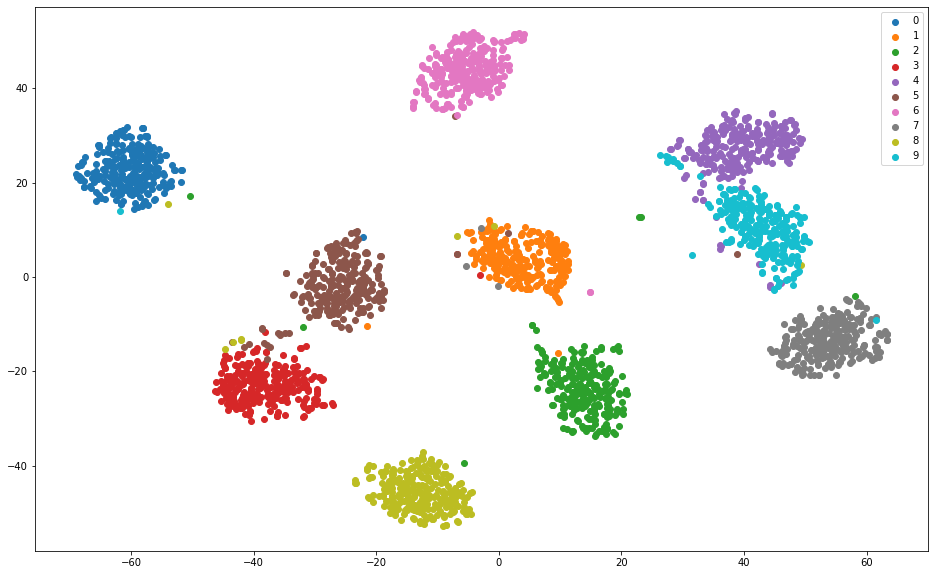

In [8]:
# Doing a naive plotting here.
# What needs to be done:
# 1. Change the color for each cluster - Done
# 2. Differentiate the color of the cluster from its centroid - Undone
# 3. Have a legend print out all the cluster with its label - Done

# What if we use only the k-means from the clusters ?
start = 0
plt.figure(figsize=(16,10))
cmaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuBuGn']

for i,end in enumerate(indices):
    plt.scatter(tsne_points[start:end,0], tsne_points[start:end,1], cmap=cmaps[i], label=i)
    plt.legend()
    start = end
    
plt.savefig('mnist-k-medioids-clustermaps.png')

In [9]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw



c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Epoch 0 - Training loss: 0.39534745876119337
Epoch 1 - Training loss: 0.18977062247876228
Epoch 2 - Training loss: 0.14066200871775145
Epoch 3 - Training loss: 0.11494115647772497
Epoch 4 - Training loss: 0.09625010930849656
Epoch 5 - Training loss: 0.08563544055862007
Epoch 6 - Training loss: 0.07566840373235804
Epoch 7 - Training loss: 0.06880764063717777
Epoch 8 - Training loss: 0.061834025124995425
Epoch 9 - Training loss: 0.056452280946516754
Epoch 10 - Training loss: 0.05332068498703097
Epoch 11 - Training loss: 0.04909169306311616
Epoch 12 - Training loss: 0.046359664463658516
Epoch 13 - Training loss: 0.04054995230206702
Epoch 14 - Training loss: 0.04002884835758031

Training Time (in minutes) = 2.0857666730880737
Predicted Digit = 6
Number Of Images Tested = 10000

Model Accuracy = 0.9741


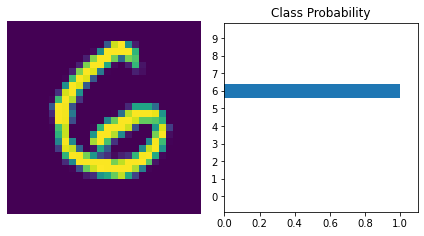

In [10]:
# Now let's start training the network

import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

trainset = datasets.MNIST('./', download=True, train=True, transform=transform)
valset = datasets.MNIST('./', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images)
loss = criterion(logps, labels)

optimizer = optim.Adam(model.parameters(), lr=0.001)
time0 = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:

        images = images.view(images.shape[0], -1)
    
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)


images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model(img)

ps = torch.exp(logps)
probab = list(ps.numpy()[0])
print("Predicted Digit =", probab.index(max(probab)))
view_classify(img.view(1, 28, 28), ps)

correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():
        logps = model(img)

    
    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

In [23]:
classlabellist = defaultdict(list)
with torch.no_grad():
    for images, labels in trainloader:

        images = images.view(images.shape[0], -1)

        output = model(images)
        
        for i in range(10):
            classno = output[np.where(labels==i)[0]].numpy()
            classlabellist[i].extend(classno)
            
            
returnlist = []
for label in classlabellist:
    returnlist.append(np.array(classlabellist[label]))

In [18]:
label_list = []
indices = []
for number in range(10):
    kmeans = KMedoids(n_clusters = 256)
    kmeans.fit(returnlist[number])
    returnlist[number] = kmeans.cluster_centers_
    label_list.append(returnlist[number][:])
    if not indices:
        indices.append(returnlist[number].shape[0])
    else:         
        indices.append(indices[-1] + returnlist[number].shape[0])
        
label_list = np.concatenate(label_list, axis=0)

In [22]:
returnlist[1].shape

(256, 10)

In [19]:
# We do the TSNE transform on total_list
from sklearn.manifold import TSNE
label_points = TSNE(n_components=2, perplexity = 50, n_iter = 1000).fit_transform(label_list)

c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


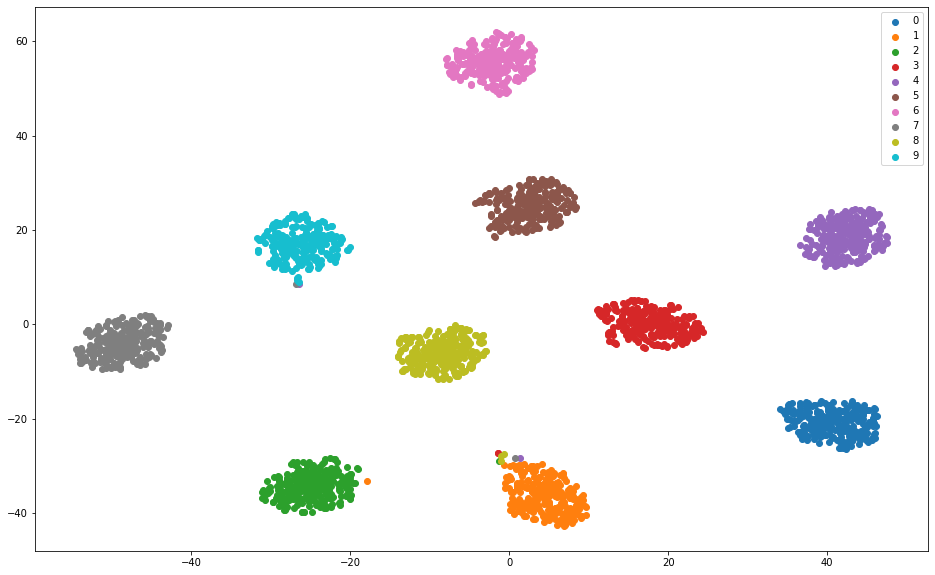

In [26]:
# Doing a naive plotting here.
# What needs to be done:
# 1. Change the color for each cluster - Done
# 2. Differentiate the color of the cluster from its centroid - Undone
# 3. Have a legend print out all the cluster with its label - Done
start = 0
plt.figure(figsize=(16,10))
cmaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuBuGn']

for i,end in enumerate(indices):
    plt.scatter(label_points[start:end,0], label_points[start:end,1], cmap=cmaps[i], label=i)
    plt.legend()
    start = end
    
plt.savefig('labels_clustering.png')

In [74]:
# Let's create adversarial examples
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
eps = 0.3
x_batch, y_batch = next(iter(valloader))
x = x_batch[0]
y = y_batch[0]
x_fgm = fast_gradient_method(model, x.view(1,784), eps, np.inf)

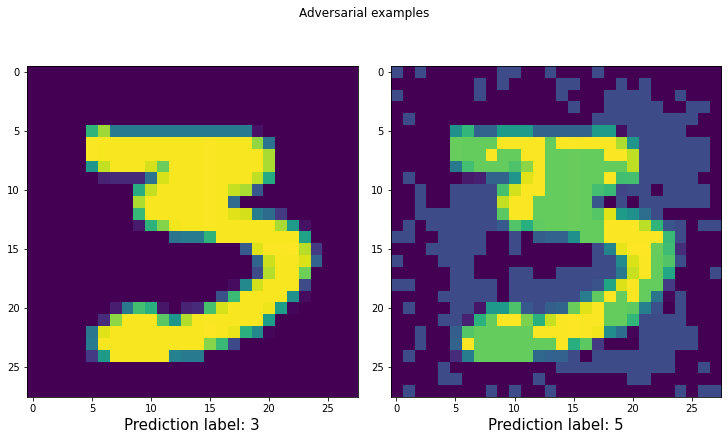

In [84]:
logps = model(x_fgm)
ps = torch.exp(logps)
probab = list(ps.detach().numpy()[0])
pred_label = probab.index(max(probab))
fig, axs = plt.subplots(1,2,figsize=(10, 6),constrained_layout=True)
fig.suptitle('Adversarial examples')
axs[0].set_xlabel('Prediction label: ' + str(y.item()), fontsize=15)
axs[0].imshow(x.squeeze(0))
axs[1].set_xlabel('Prediction label: ' + str(pred_label), fontsize=15)
axs[1].imshow(x_fgm.reshape((28,28)).detach().numpy())
plt.show()

### Looking at just 0s

In [69]:
# What is being done here:
# We are collecting all the images by classes
# Each entry in the 'numbers' list is 
# a numpy array of all the images by class
numbers = []
for i in range(10):
    classno = X_train[np.where(y_train==i)]
    numbers.append(classno)

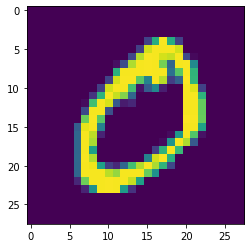

In [70]:
plt.imshow(numbers[0][0].reshape((28,28)))
plt.show()

In [73]:
# Let's create adversarial examples
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
eps = 0.1
x = torch.from_numpy(numbers[0])
y = 0
x_fgm = fast_gradient_method(model, x, eps, np.inf).detach().numpy()

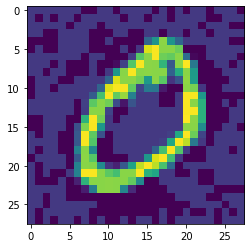

In [74]:
plt.imshow(x_fgm[0].reshape((28,28)))
plt.show()

In [76]:
## Testing model accuracy on advsersarial samples

correct_count, all_count = 0, 0
for i in range(len(x_fgm)):
    img = torch.from_numpy(x_fgm[i]).unsqueeze(axis=0)
    with torch.no_grad():
        logps = model(img)


    ps = torch.exp(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = 0
    if(true_label == pred_label):
        correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 5923

Model Accuracy = 0.33040688840114807


(5923, 784)
(5923, 784)


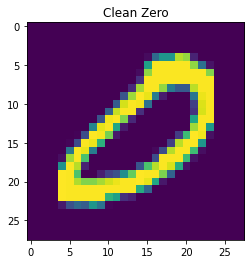

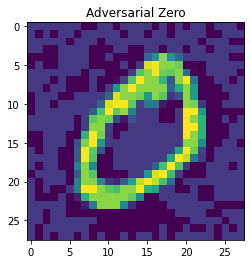

In [82]:
print(numbers[0].shape)
print(x_fgm.shape)

boundary = len(numbers[0])
clean_and_adv = np.concatenate((numbers[0], x_fgm))
plt.imshow(clean_and_adv[boundary - 1].reshape((28,28)))
plt.title("Clean Zero")
plt.show()

plt.imshow(clean_and_adv[boundary].reshape((28,28)))
plt.title("Adversarial Zero")
plt.show()

In [83]:
# Do TNSE transform on network outputs for 0 class
from sklearn.manifold import TSNE
low_dim_zeros = TSNE(n_components=2, perplexity = 50, n_iter = 10000).fit_transform(clean_and_adv)

c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


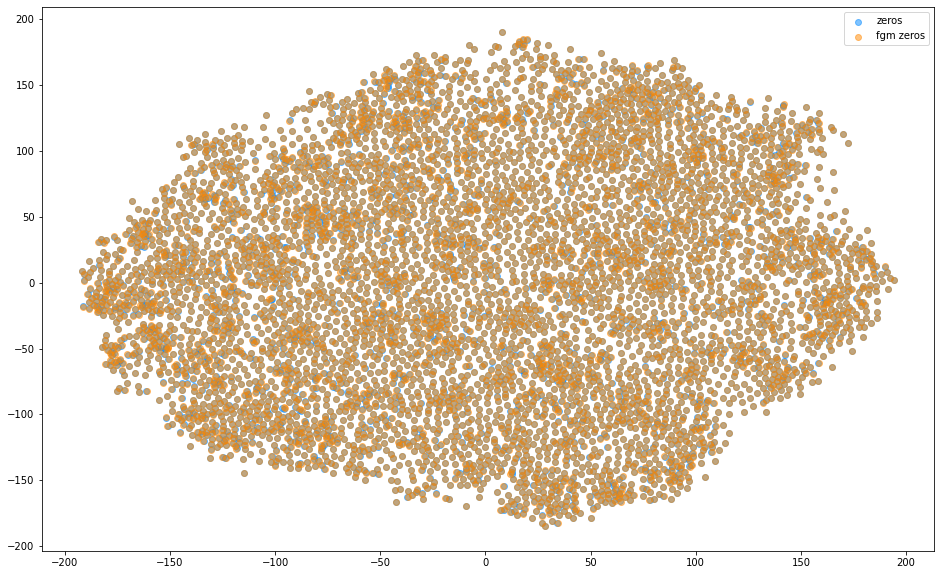

In [92]:
## With an epsilon of only 0.1, clean and adversarial images are basically on top of each other
plt.figure(figsize=(16,10))
plt.scatter(low_dim_zeros[:boundary,0], low_dim_zeros[:boundary,1], c='#0088ff', label='zeros', alpha=0.5)
plt.scatter(low_dim_zeros[boundary:,0], low_dim_zeros[boundary:,1], c='#ff8800', label='fgm zeros', alpha=0.5)
plt.legend()

In [85]:
with torch.no_grad():
    output = model(torch.from_numpy(clean_and_adv))

In [86]:
zeros_nn_output = TSNE(n_components=2, perplexity = 50, n_iter = 1000).fit_transform(output)

c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\users\jason\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


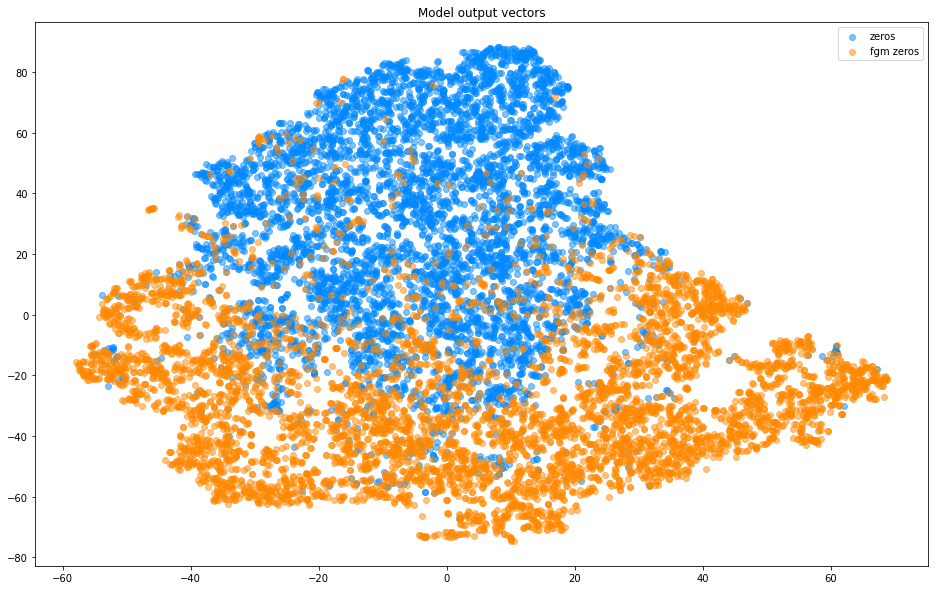

In [91]:
# Although there is some overlap, there is a clear separation between output vectors for clean and adversarial images of one class
plt.figure(figsize=(16,10))
plt.title("Model output vectors")
plt.scatter(zeros_nn_output[:boundary,0], zeros_nn_output[:boundary,1], c='#0088ff', label='zeros', alpha=0.5)
plt.scatter(zeros_nn_output[boundary:,0], zeros_nn_output[boundary:,1], c='#ff8800', label='fgm zeros', alpha=0.5)
plt.legend()